In [1]:
import numpy as np
import pandas as pd

In [2]:
# Load patient master data
pt = pd.read_csv('../data/Train/csv/patients.csv')
co = pd.read_csv('../data/Train/csv/conditions.csv')

In [3]:
# Define the mapping from DESCRIPTION to result DataFrame column names
description_to_column = {
    'Body mass index 30+ - obesity (finding)': 'Obese',
    'Body mass index 40+ - severely obese (finding)': 'Obese',
    'Essential hypertension (disorder)': 'Hypertension',
    'Atrial fibrillation (disorder)': 'Atrial_Fibrillation',
    'Diabetes mellitus type 2 (disorder)': 'Diabetes_Type2',
    'Seizure disorder (disorder)': 'Seizure_Disorder',
    'Major depression single episode (disorder)': 'Depression_Anxiety',
    'Major depressive disorder (disorder)': 'Depression_Anxiety',
    'Pulmonary emphysema (disorder)': 'COPD',
    'Respiratory distress (finding)': 'COPD',
    'Anemia (disorder)': 'Anemia',
    'Chronic kidney disease stage 1 (disorder)': 'Chronic_Kidney_Disease',
    'Chronic kidney disease stage 2 (disorder)': 'Chronic_Kidney_Disease',
    'Chronic kidney disease stage 3 (disorder)': 'Chronic_Kidney_Disease',
    'Chronic kidney disease stage 4 (disorder)': 'Chronic_Kidney_Disease',
    'Chronic kidney disease stage 5 (disorder)': 'Chronic_Kidney_Disease',
    'Laceration - injury (disorder)': 'MildInjury_Pain',
    'Injury of knee (disorder)': 'MildInjury_Pain',
    'Injury of tendon of the rotator cuff of shoulder (disorder)': 'MildInjury_Pain',
    'Concussion injury of brain (disorder)': 'MildInjury_Pain',
    'Injury of neck (disorder)': 'MildInjury_Pain',
    'Childhood asthma (disorder)': 'Asthma',
    'Asthma (disorder)': 'Asthma',
    'Appendicitis (disorder)': 'Appendicitis',
    'Drug overdose': 'Drug_Overdose'
}

# Replace DESCRIPTION in 'co' with corresponding column names and rename to CONDITION_SIMPLE
co['CONDITION_SIMPLE'] = co['DESCRIPTION'].map(description_to_column)

# Filter out any rows in 'co' where 'CONDITION_SIMPLE' is NaN
co = co.dropna(subset=['CONDITION_SIMPLE'])

# Create dummy variables for the new 'CONDITION_SIMPLE' column
conditions = pd.get_dummies(co['CONDITION_SIMPLE'])
co_expanded = co[['PATIENT']].join(conditions)  # Only join the 'PATIENT' column with the dummy variables

# Aggregate conditions by patient
co_grouped = co_expanded.groupby('PATIENT').sum().clip(upper=1).reset_index()
co_grouped

PATIENT  Anemia  Appendicitis  Asthma  \
0     001eaca0-15dc-89b7-e88d-62e3b72e3c12       0             0       0   
1     0027a2c3-6f86-b683-cac4-5ac409c14b13       0             0       0   
2     005d13a9-dd3e-0d7b-f9cf-ed71c9595174       0             0       0   
3     005eb147-c797-8c12-b36d-3ed503bc1acc       0             0       1   
4     0069ce6b-9027-a5ee-93e4-11fc408d1f27       0             0       0   
...                                    ...     ...           ...     ...   
4523  ffe9d142-ea7f-ed22-ad6a-20e437b271df       0             0       0   
4524  ffeafc74-78d4-b2a8-b497-31b0035b9c67       0             0       0   
4525  ffebe97f-caea-96c4-77c1-cd1131268228       1             0       0   
4526  ffed5ac4-37d0-f163-5a01-335130f30a90       0             0       0   
4527  fff78a10-78b2-1e04-49b7-9a9826f3529d       1             0       0   

      Atrial_Fibrillation  COPD  Chronic_Kidney_Disease  Depression_Anxiety  \
0                       0     0                       0                   0   
1                       0     1                       0                   0   
2                       0     0                       0                   0   
3                       0     0                       0                   0   
4                       0     0                       0                   0   
...                   ...   ...                     ...                 ...   
4523                    0     1                       1                   0   
4524                    0     0                       0                   0   
4525                    0     0                       0                   0   
4526                    0     0                       0                   0   
4527                    1     0                       1                   0   

      Diabetes_Type2  Drug_Overdose  Hypertension  MildInjury_Pain  Obese  \
0                  0              0             1                0      1   
1                  0              0             0                0      1   
2                  0              0             1                1      1   
3                  0              0             0                0      0   
4                  0              0             0                0      1   
...              ...            ...           ...              ...    ...   
4523               0              0             1                0      1   
4524               0              0             0                1      1   
4525               0              0             0                1      1   
4526               0              0             0                1      0   
4527               0              1             1                0      1   

      Seizure_Disorder  
0                    0  
1                    0  
2                    1  
3                    0  
4                    0  
...                ...  
4523                 0  
4524                 0  
4525                 0  
4526                 0  
4527                 0  

[4528 rows x 14 columns]

In [4]:

# Process patient information
today = pd.Timestamp('2025-01-01')
pt['Age'] = (today - pd.to_datetime(pt['BIRTHDATE'])).dt.days // 365
pt['Age_Pediatric'] = (pt['Age'] < 18).astype(int)
pt['Age_Elderly'] = (pt['Age'] > 65).astype(int)
pt['Sex_Male'] = (pt['GENDER'] == 'M').astype(int)
pt['Sex_Female'] = (pt['GENDER'] == 'F').astype(int)

# Merge patient info with conditions
pt_renamed = pt.rename(columns={'Id': 'PATIENT'})
patient_conditions = pt_renamed[['PATIENT', 'Age_Pediatric', 'Age_Elderly', 'Sex_Male', 'Sex_Female']]
patient_data = patient_conditions.merge(co_grouped, on='PATIENT', how='left').fillna(0)

# Ensure the result only has the columns you requested
final_columns = [
    'PATIENT', 'Age_Pediatric', 'Age_Elderly', 'Sex_Male', 'Sex_Female',
    'Obese', 'Hypertension', 'Atrial_Fibrillation', 'Diabetes_Type2',
    'Seizure_Disorder', 'Depression_Anxiety', 'COPD', 'Anemia',
    'Chronic_Kidney_Disease', 'MildInjury_Pain', 'Asthma', 'Appendicitis',
    'Drug_Overdose'
]
patient_data = patient_data[final_columns]
patient_data.rename(columns={'PATIENT': 'patient_id'}, inplace=True)


In [5]:
patient_data.head(2)

patient_id  Age_Pediatric  Age_Elderly  Sex_Male  \
0  80708456-1afe-9125-dd92-932ed402cf83              0            0         1   
1  7a219b32-8414-b18b-d7f6-0907e0e2b1af              0            0         1   

   Sex_Female  Obese  Hypertension  Atrial_Fibrillation  Diabetes_Type2  \
0           0    0.0           0.0                  0.0             0.0   
1           0    1.0           0.0                  0.0             0.0   

   Seizure_Disorder  Depression_Anxiety  COPD  Anemia  Chronic_Kidney_Disease  \
0               0.0                 0.0   0.0     0.0                     0.0   
1               0.0                 0.0   0.0     1.0                     0.0   

   MildInjury_Pain  Asthma  Appendicitis  Drug_Overdose  
0              0.0     0.0           0.0            0.0  
1              0.0     0.0           0.0            0.0

In [11]:
# # Mock patient data and the modifications to the master spec
# patient_data = pd.DataFrame({
#     'patient_id': [1, 2],
#     'age': [25, 70],
#     'sex': ['M', 'F'],
#     'Obese': [1, 0],
#     'Hypertension': [0, 1],
#     'Atrial_Fibrillation': [1, 0]
# })

states = [
    "Neutral", "Cardiac Ischaemia", "Sepsis", "Acute Anxiety/Panic",
    "Breathing Difficulty", "Hypovolaemia", "Arrhythmic Flare", "Hypoglycemia",
    "TIA", "Bathroom (harmless)", "White Coat Syndrome (harmless)", "STEMI (crisis)",
    "Septic Shock (crisis)", "Compromised Airway (crisis)", "Haemorrhagic Shock (crisis)",
    "Stroke (crisis)", "Death"
]

basis_transition_matrix = np.array([
    [0.70, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.05, 0.05, 0, 0, 0, 0, 0, 0],
    [0.50, 0.30, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20, 0, 0, 0, 0, 0],
    [0.15, 0, 0.45, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.40, 0, 0, 0, 0],
    [0.80, 0, 0, 0.20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0.50, 0, 0, 0, 0.35, 0, 0, 0, 0, 0, 0, 0, 0.15, 0, 0, 0, 0],
    [0.35, 0, 0, 0, 0, 0.40, 0, 0, 0, 0, 0, 0, 0, 0, 0.25, 0, 0],
    [0.65, 0, 0, 0, 0, 0, 0.20, 0, 0, 0, 0, 0.15, 0, 0, 0, 0, 0],
    [0.75, 0, 0, 0, 0, 0, 0, 0.17, 0, 0, 0, 0, 0, 0.08, 0, 0, 0],
    [0.70, 0, 0, 0, 0, 0, 0, 0, 0.10, 0, 0, 0, 0, 0, 0, 0.20, 0],
    [1.00, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1.00, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0.80, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20],
    [0, 0, 0.90, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.10],
    [0, 0, 0, 0, 0, 0, 0, 0.50, 0, 0, 0, 0, 0, 0, 0, 0, 0.50],
    [0, 0, 0, 0, 0, 0.70, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.30],
    [0, 0, 0, 0, 0, 0, 0, 0, 0.85, 0, 0, 0, 0, 0, 0, 0, 0.15],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00]
])


# Base transition matrix
basis_transition_matrix_comb = {
    "states": states,
    "transition_matrix": basis_transition_matrix
}


# Define the MASTER_SPEC as described in the user's scenario
MASTER_SPEC = {
    "Age_Pediatric": {"risk_modifiers": {"sepsis_warning": 1.0, "pre_mi_warning": 0.5}},
    "Age_Elderly": {"risk_modifiers": {"pre_mi_warning": 1.5, "sepsis_warning": 1.5}},
    "Sex_Male": {"risk_modifiers": {"pre_mi_warning": 1.2}},
    "Sex_Female": {"risk_modifiers": {"pre_mi_warning": 1.0}},
    "Obese": {"risk_modifiers": {"pre_mi_warning": 2.0, "stemi_crisis": 1.5, "sepsis_warning": 1.0}},
    "Underweight": {"risk_modifiers": {"infection_warning": 1.3}},
    "Hypertension": {"risk_modifiers": {"pre_mi_warning": 2.0, "stemi_crisis_if_in_pre_mi_warning": 1.5}},
    "Atrial_Fibrillation": {"risk_modifiers": {"pre_mi_warning": 1.2, "stroke_crisis": 2.0}},
    "Diabetes_Type2": {"risk_modifiers": {"hypoglycemia_warning": 1.5}},
    "Seizure_Disorder": {"risk_modifiers": {"seizure_crisis": 1.5}},
    "Depression_Anxiety": {"risk_modifiers": {"panic_warning": 2.0}},
    "COPD": {"risk_modifiers": {"breathing_difficulty_warning": 1.5, "compromised_airway_crisis_if_in_breathing_difficulty": 1.3}},
    "Hemophilia": {"risk_modifiers": {"hypovolemia_warning": 2.0, "hemorrhagic_crisis_if_in_hypovolemia": 2.0}},
    "Anemia": {"risk_modifiers": {"hemorrhagic_crisis_if_in_hypovolemia": 1.5, "breathing_difficulty_warning": 1.2}},
    "Chronic_Kidney_Disease": {"risk_modifiers": {"sepsis_warning": 1.2, "hemorrhagic_crisis_if_in_hypovolemia": 1.2}},
    "MildInjury_Pain": {},
    "ChestPain": {"risk_modifiers": {"cardiac_ischaemia_warning": 0.8}},
    "Asthma": {"risk_modifiers": {"breathing_difficulty_warning": 1.0}},
    "Appendicitis": {"risk_modifiers": {"sepsis_warning": 1.3}},
    "Drug_Overdose": {"risk_modifiers": {"breathing_difficulty_warning": 1.5}},
}

state_mapping = {
    "sepsis_warning": "Sepsis",
    "pre_mi_warning": "Cardiac Ischaemia",
    "stemi_crisis": "STEMI (crisis)",
    "hypoglycemia_warning": "Hypoglycemia",
    "seizure_crisis": "TIA",
    "panic_warning": "Acute Anxiety/Panic",
    "breathing_difficulty_warning": "Breathing Difficulty",
    "compromised_airway_crisis_if_in_breathing_difficulty": "Compromised Airway (crisis)",
    "hypovolemia_warning": "Hypovolaemia",
    "hemorrhagic_crisis_if_in_hypovolemia": "Haemorrhagic Shock (crisis)",
    "stroke_crisis": "Stroke (crisis)"
}


def create_patient_specific_matrices(basis_transition_matrix, patient_data, master_spec, state_mapping):
    states = basis_transition_matrix['states']
    base_matrix = np.array(basis_transition_matrix['transition_matrix'])
    
    patient_matrices = {}
    
    for index, patient in patient_data.iterrows():
        #print(patient)
        patient_matrix = np.copy(base_matrix)
        
        for characteristic, details in master_spec.items():
            #print(characteristic, details)
            if patient.get(characteristic, 0) == 1 and "risk_modifiers" in details:
                #print(1)
                for modified_state, modifier in details['risk_modifiers'].items():
                    #print(modified_state, modifier)
                    if modified_state in state_mapping and state_mapping[modified_state] in states:
                        #print(2)
                        from_state_index = states.index(state_mapping[modified_state])
                        #print(from_state_index)
                        for to_state_index, _ in enumerate(states):
                            #print('current:', patient_matrix[to_state_index, from_state_index])
                            patient_matrix[to_state_index, from_state_index] *= modifier
                        
        #print(patient_matrix)
        #break
        
        patient_matrices[patient['patient_id']] = patient_matrix
    
    return patient_matrices


# Applying the function with the mapping
patient_matrices = create_patient_specific_matrices(basis_transition_matrix_comb, patient_data, MASTER_SPEC, state_mapping)
patient_matrices


{'80708456-1afe-9125-dd92-932ed402cf83': array([[0.7  , 0.03 , 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
         0.05 , 0.05 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.5  , 0.36 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.2  , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.15 , 0.   , 0.45 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.4  , 0.   , 0.   , 0.   , 0.   ],
        [0.8  , 0.   , 0.   , 0.2  , 0.   , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
        [0.5  , 0.   , 0.   , 0.   , 0.35 , 0.   , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.15 , 0.   , 0.   , 0.   , 0.   ],
        [0.35 , 0.   , 0.   , 0.   , 0.   , 0.4  , 0.   , 0.   , 0.   ,
         0.   , 0.   , 0.   , 0.   , 0.   , 0.25 , 0.   , 0.   ],
        [0.65 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.2  , 0.   , 0.   ,
         0.   , 0.   , 0.15 , 0.   , 0.   , 0.   , 0.   , 0.

In [12]:


# Function to print patient attributes with a value of 1
def print_patient_attributes(patient_id):
    patient_row = patient_data[patient_data['patient_id'] == patient_id]
    if not patient_row.empty:
        attributes = patient_row.iloc[0]
        print(f"Patient {patient_id} attributes with value 1:")
        for col in patient_data.columns[1:]:  # Skipping 'patient_id' column
            if attributes[col] == 1:
                print(f"  {col}")
    else:
        print(f"No data found for patient {patient_id}.")

# Function to compare matrices and print differences
def compare_matrices(patient_id, patient_matrix):
    print(f"Comparing matrix for patient {patient_id}:")
    differences = np.where(patient_matrix != basis_transition_matrix)
    if len(differences[0]) == 0:
        print("No differences found.\n")
    else:
        for i, j in zip(differences[0], differences[1]):
            print(f"  From '{states[i]}' to '{states[j]}':")
            print(f"    Base value: {basis_transition_matrix[i][j]}, Patient value: {patient_matrix[i][j]}")
    print()

# Iterate over the patient matrices and compare each to the base matrix
for patient_id, matrix in patient_matrices.items():
    print_patient_attributes(patient_id)
    compare_matrices(patient_id, matrix)


Patient 80708456-1afe-9125-dd92-932ed402cf83 attributes with value 1:
  Sex_Male
Comparing matrix for patient 80708456-1afe-9125-dd92-932ed402cf83:
  From 'Neutral' to 'Cardiac Ischaemia':
    Base value: 0.025, Patient value: 0.03
  From 'Cardiac Ischaemia' to 'Cardiac Ischaemia':
    Base value: 0.3, Patient value: 0.36
  From 'STEMI (crisis)' to 'Cardiac Ischaemia':
    Base value: 0.8, Patient value: 0.96

Patient 7a219b32-8414-b18b-d7f6-0907e0e2b1af attributes with value 1:
  Sex_Male
  Obese
  Anemia
Comparing matrix for patient 7a219b32-8414-b18b-d7f6-0907e0e2b1af:
  From 'Neutral' to 'Cardiac Ischaemia':
    Base value: 0.025, Patient value: 0.06
  From 'Neutral' to 'Breathing Difficulty':
    Base value: 0.025, Patient value: 0.03
  From 'Cardiac Ischaemia' to 'Cardiac Ischaemia':
    Base value: 0.3, Patient value: 0.72
  From 'Cardiac Ischaemia' to 'STEMI (crisis)':
    Base value: 0.2, Patient value: 0.30000000000000004
  From 'Breathing Difficulty' to 'Breathing Difficulty

In [15]:
# Function to normalize transition matrices to ensure each row sums to 1
def normalize_matrix(matrix):
    row_sums = matrix.sum(axis=1, keepdims=True)
    # Avoid division by zero in case of rows with all zeros
    row_sums[row_sums == 0] = 1
    return matrix / row_sums

# Normalize all patient matrices
normalized_patient_matrices = {patient_id: normalize_matrix(matrix) for patient_id, matrix in patient_matrices.items()}

In [13]:
state_durations = {
    "Neutral": [10, 60],
    "Cardiac Ischaemia": [15, 45],
    "Sepsis": [30, 60],
    "Acute Anxiety/Panic": [10, 30],
    "Breathing Difficulty": [15, 40],
    "Hypovolaemia": [20, 50],
    "Arrhythmic Flare": [10, 30],
    "Hypoglycemia": [10, 25],
    "TIA": [15, 35],
    "Bathroom (harmless)": [5, 10],
    "White Coat Syndrome (harmless)": [5, 20],
    "STEMI (crisis)": [20, 60],
    "Septic Shock (crisis)": [30, 60],
    "Compromised Airway (crisis)": [20, 50],
    "Haemorrhagic Shock (crisis)": [25, 55],
    "Stroke (crisis)": [20, 60],
    "Death": [5, 60]  # Assuming the observation time until confirmation
}


In [21]:
import numpy as np

# Fixing the random seed for reproducibility
np.random.seed(42)

# Function to simulate state sequences ensuring state for every 5-minute interval
def simulate_patient_states(patient_id, transition_matrix, debug=False):
    total_time = 300  # Total simulation time in minutes (5 hours)
    time_step = 5     # Time step in minutes

    # Start in 'Neutral' state
    current_state = 'Neutral'
    states_sequence = []
    current_time = 0

    # Immediately determine the first state from 'Neutral'
    state_index = states.index(current_state)
    next_state_index = np.random.choice(range(len(states)), p=transition_matrix[state_index])
    current_state = states[next_state_index]

    if debug:
        print(f"Initial state transition from 'Neutral' to '{current_state}'")

    while current_time < total_time:
        # Determine the duration for the current state, ensuring it doesn't exceed total_time
        duration_range = state_durations[current_state]
        possible_durations = list(range(duration_range[0], duration_range[1] + 1, 5))
        state_duration = np.random.choice(possible_durations)
        
        # Calculate the end time for the current state, not to exceed total_time
        end_time = min(current_time + state_duration, total_time)

        if debug:
            print(f"At minute {current_time}, transitioning to '{current_state}' for {state_duration} minutes")

        # Record the current state at each 5-minute interval until the state changes
        while current_time < end_time:
            states_sequence.append(current_state)
            current_time += time_step
        
        # If current time is still less than total time, determine next state
        if current_time < total_time:
            state_index = states.index(current_state)
            next_state_index = np.random.choice(range(len(states)), p=transition_matrix[state_index])
            current_state = states[next_state_index]
            if debug:
                print(f"At minute {current_time}, transitioning to '{current_state}'")

    return states_sequence

# Generate state sequences for each patient
patient_state_sequences = {}
first_patient = True
for patient_id, matrix in normalized_patient_matrices.items():
    if first_patient:
        patient_state_sequences[patient_id] = simulate_patient_states(patient_id, matrix, debug=True)
        first_patient = False  # Only debug the first patient
    else:
        patient_state_sequences[patient_id] = simulate_patient_states(patient_id, matrix)

# Print the state sequences for the first patient
for patient_id, sequences in patient_state_sequences.items():
    print(f"Patient {patient_id} state sequence over 5 hours:")
    print(sequences)
    break  # Break after printing the first patient


Initial state transition from 'Neutral' to 'Neutral'
At minute 0, transitioning to 'Neutral' for 60 minutes
At minute 60, transitioning to 'Breathing Difficulty'
At minute 60, transitioning to 'Breathing Difficulty' for 35 minutes
At minute 95, transitioning to 'Neutral'
At minute 95, transitioning to 'Neutral' for 20 minutes
At minute 115, transitioning to 'Neutral'
At minute 115, transitioning to 'Neutral' for 60 minutes
At minute 175, transitioning to 'Hypoglycemia'
At minute 175, transitioning to 'Hypoglycemia' for 25 minutes
At minute 200, transitioning to 'Neutral'
At minute 200, transitioning to 'Neutral' for 20 minutes
At minute 220, transitioning to 'Neutral'
At minute 220, transitioning to 'Neutral' for 15 minutes
At minute 235, transitioning to 'Cardiac Ischaemia'
At minute 235, transitioning to 'Cardiac Ischaemia' for 40 minutes
At minute 275, transitioning to 'Neutral'
At minute 275, transitioning to 'Neutral' for 30 minutes
Patient 80708456-1afe-9125-dd92-932ed402cf83 sta

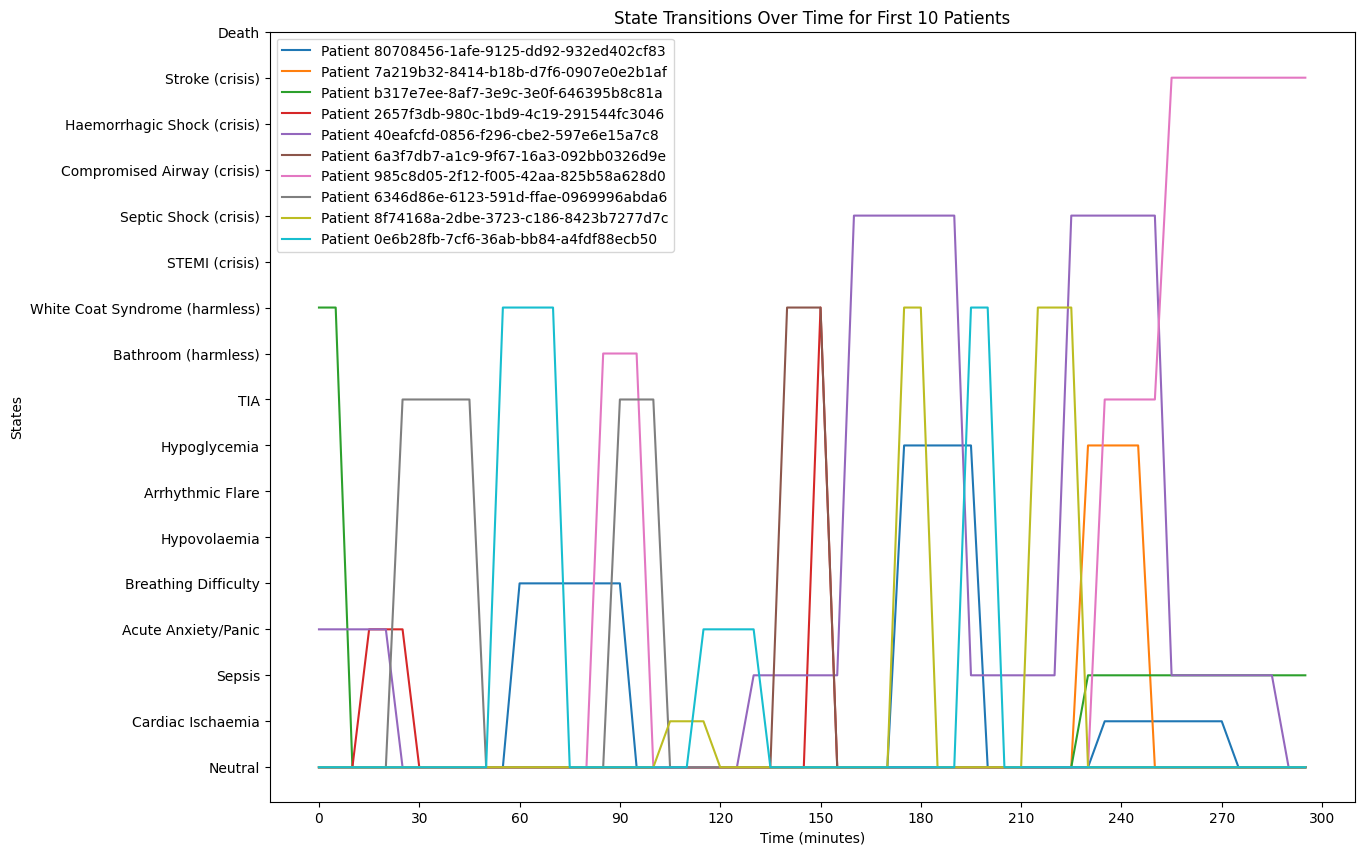

In [22]:
import matplotlib.pyplot as plt

# Convert state names to numerical values for plotting
state_to_index = {state: idx for idx, state in enumerate(states)}

# Prepare the figure
plt.figure(figsize=(14, 10))
for idx, (patient_id, sequences) in enumerate(patient_state_sequences.items()):
    if idx >= 10:  # Limit to the first 10 patients
        break
    # Convert state names to indices for plotting
    state_indices = [state_to_index[state] for state in sequences]
    # Create x values representing each 5-minute interval
    x_values = list(range(0, 300, 5))
    # Plot
    plt.plot(x_values, state_indices, label=f'Patient {patient_id}')

# Set the labels and title
plt.xlabel('Time (minutes)')
plt.ylabel('States')
plt.title('State Transitions Over Time for First 10 Patients')
plt.xticks(range(0, 301, 30))  # Mark each hour
plt.yticks(range(len(states)), labels=states)  # Ensure state labels are used on y-axis

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Select the first five patients' state sequences
first_five_patients = {k: patient_state_sequences[k] for k in list(patient_state_sequences.keys())[:5]}

# Prepare the plot
fig, ax = plt.subplots(figsize=(10, 8))

# Assign a numeric value to each state for plotting
state_values = {state: i for i, state in enumerate(states)}

# Plot each patient's state sequence
for patient_id, sequences in first_five_patients.items():
    # Map state names to numeric values
    state_sequence_values = [state_values[state] for state in sequences]
    # Compute time points for the state changes
    time_points = np.arange(0, len(state_sequence_values) * 5, 5)
    # Ensure time points do not exceed 300 minutes
    time_points = time_points[:len(state_sequence_values)]
    ax.plot(time_points, state_sequence_values, label=f'Patient {patient_id}', marker='o', linestyle='-')

# Set the y-axis labels to state names
ax.set_yticks(list(state_values.values()))
ax.set_yticklabels(list(state_values.keys()))

# Set the axis labels and plot title
ax.set_xlabel('Minutes')
ax.set_ylabel('States')
ax.set_title('State Development Over 300 Minutes for First 5 Patients')

# Add a legend
ax.legend()

# Show grid
ax.grid(True)

# Show the plot
plt.show()


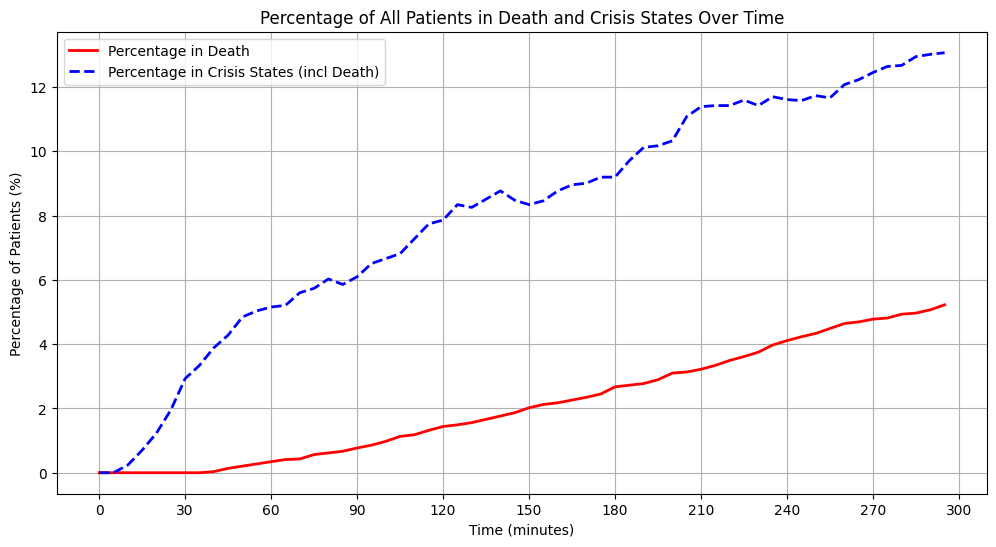

In [26]:
import matplotlib.pyplot as plt

# Define crisis states
crisis_states = [
    "STEMI (crisis)", "Septic Shock (crisis)", "Compromised Airway (crisis)",
    "Haemorrhagic Shock (crisis)", "Stroke (crisis)", 'Death'
]

# Number of intervals (5 minutes each over 300 minutes)
num_intervals = int(300 / 5)

# Prepare lists to count 'Death' and 'Crisis' states at each time interval
death_counts = [0] * num_intervals
crisis_counts = [0] * num_intervals

# Total number of patients
total_patients = len(patient_state_sequences)

# Calculate the number of patients in 'Death' and 'Crisis' states at each interval
for sequences in patient_state_sequences.values():
    for i, state in enumerate(sequences):
        if state == "Death":
            death_counts[i] += 1
        if state in crisis_states:
            crisis_counts[i] += 1

# Calculate the percentage of patients in 'Death' and 'Crisis' states at each interval
death_percentages = [(count / total_patients) * 100 for count in death_counts]
crisis_percentages = [(count / total_patients) * 100 for count in crisis_counts]

# Time intervals for plotting
time_intervals = list(range(0, 300, 5))

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(time_intervals, death_percentages, label='Percentage in Death', color='red', linewidth=2)
plt.plot(time_intervals, crisis_percentages, label='Percentage in Crisis States (incl Death)', color='blue', linestyle='--', linewidth=2)
plt.xlabel('Time (minutes)')
plt.ylabel('Percentage of Patients (%)')
plt.title('Percentage of All Patients in Death and Crisis States Over Time')
plt.grid(True)
plt.xticks(range(0, 301, 30))  # Mark each hour
plt.legend()

# Show the plot
plt.show()


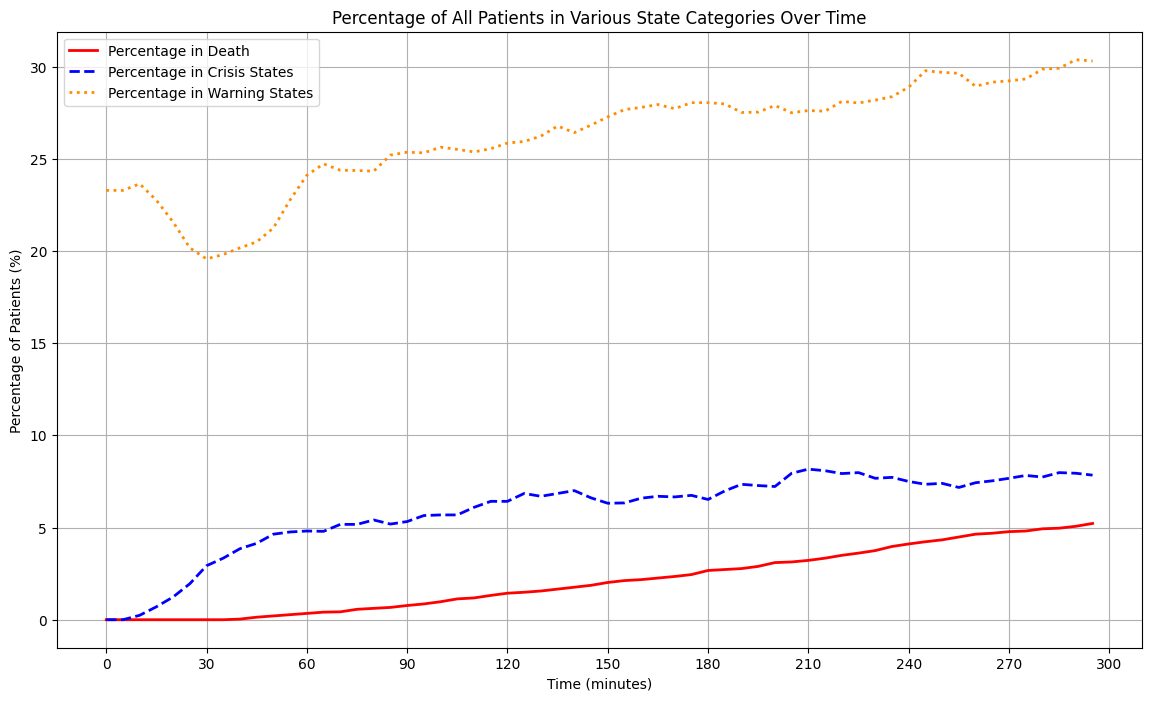

In [30]:
import matplotlib.pyplot as plt

# Define state categories
standard_states = ["Neutral", "Bathroom (harmless)", "White Coat Syndrome (harmless)"]
crisis_states = [
    "STEMI (crisis)", "Septic Shock (crisis)", "Compromised Airway (crisis)",
    "Haemorrhagic Shock (crisis)", "Stroke (crisis)"
]

# All other states are considered warning states
warning_states = [state for state in states if state not in standard_states + crisis_states + ["Death"]]

# Number of intervals (5 minutes each over 300 minutes)
num_intervals = int(300 / 5)

# Prepare lists to count states at each time interval
death_counts = [0] * num_intervals
crisis_counts = [0] * num_intervals
standard_counts = [0] * num_intervals
warning_counts = [0] * num_intervals

# Total number of patients
total_patients = len(patient_state_sequences)

# Calculate the number of patients in each state category at each interval
for sequences in patient_state_sequences.values():
    for i, state in enumerate(sequences):
        if state == "Death":
            death_counts[i] += 1
        if state in crisis_states:
            crisis_counts[i] += 1
        if state in standard_states:
            standard_counts[i] += 1
        if state in warning_states:
            warning_counts[i] += 1

# Calculate the percentage of patients in each state category at each interval
death_percentages = [(count / total_patients) * 100 for count in death_counts]
crisis_percentages = [(count / total_patients) * 100 for count in crisis_counts]
standard_percentages = [(count / total_patients) * 100 for count in standard_counts]
warning_percentages = [(count / total_patients) * 100 for count in warning_counts]

# Time intervals for plotting
time_intervals = list(range(0, 300, 5))

# Plotting the results
plt.figure(figsize=(14, 8))
plt.plot(time_intervals, death_percentages, label='Percentage in Death', color='red', linewidth=2)
plt.plot(time_intervals, crisis_percentages, label='Percentage in Crisis States', color='blue', linestyle='--', linewidth=2)
#plt.plot(time_intervals, standard_percentages, label='Percentage in Neutral States', color='green', linestyle='-.', linewidth=2)
plt.plot(time_intervals, warning_percentages, label='Percentage in Warning States', color='#FF8C00', linestyle=':', linewidth=2)

plt.xlabel('Time (minutes)')
plt.ylabel('Percentage of Patients (%)')
plt.title('Percentage of All Patients in Various State Categories Over Time')
plt.grid(True)
plt.xticks(range(0, 301, 30))  # Mark each hour
plt.legend()

# Show the plot
plt.show()
